In [1]:
# set root directory
import os

os.chdir("../")
os.getcwd()

'c:\\Users\\HP\\Desktop\\clustering-moroccan-weather-data'

In [2]:
# imports
import numpy as np
import pandas as pd

In [3]:
# imports for plots
from plotly import graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio

pio.templates.default = "plotly_white"

In [4]:
# load data
# weather variables to use
selected_cols = ["cumulative_GDD", "cumulative_PRECTOT", "cumulative_WS2M", "cumulative_RH2M"]

dict_data = {}

for col in selected_cols:
  pathname = f"data_beni_mellal/{col}.csv"

  dict_data[col] = pd.read_csv(pathname, index_col=0)

In [5]:
# function to aggregate data
# aggregation by mean
def aggregate_data(data):
  return np.mean(data.values, axis=0)

# create data frame of aggregated data
aggregated_data = pd.DataFrame()

for col in selected_cols:
  aggregated_data[col] = aggregate_data(dict_data[col])

aggregated_data

,cumulative_GDD,cumulative_PRECTOT,cumulative_WS2M,cumulative_RH2M
0,17.098333,0.484103,1.469744,48.353846
1,34.242308,1.049744,3.045897,95.663333
2,51.643205,2.273077,4.622308,144.230000
3,68.486795,3.307692,6.314359,195.346410
4,84.800641,4.794359,7.909487,249.009231
...,...,...,...,...
264,3516.146538,450.868718,418.623590,14470.624872
265,3542.523462,451.185128,420.431538,14499.573590
266,3569.020128,451.293077,422.212821,14528.669744
267,3595.831410,451.430000,423.946410,14557.101795


In [6]:
# train a standard scaler
from sklearn.preprocessing import StandardScaler

# build then train
standard_scaler = StandardScaler()
standard_scaler.fit(aggregated_data)

# transform data 
standarized_data = pd.DataFrame(standard_scaler.transform(aggregated_data), columns=selected_cols)

In [7]:
# check aggregation
fig = go.Figure(data=[
                      go.Scatter(y=standarized_data[col], name=col)
                      for col in selected_cols
])

fig.show()

In [8]:
# perform explanatory PCA decomposition
from sklearn.decomposition import PCA

# build and fit
pca = PCA()
pca.fit(standarized_data)

print(pca.explained_variance_ratio_)
# print(pca.components_)

[9.87653030e-01 1.22051935e-02 1.14170070e-04 2.76061870e-05]


In [9]:
# stacked bar chart view explained variance ratio
# pick up the appropriate number of component

component_names = [f"component_{i}" for i in range(1, len(selected_cols) + 1)]

fig = go.Figure(data=[
                      go.Bar(y=["Explained variance ratio"], x=[pca.explained_variance_ratio_[i]], name=component_names[i], orientation='h')
                      for i in range(len(selected_cols))
])


fig.update_layout(
    title_text="Explained variance ratio for each PC",
    height=500,
    width=1000,
    barmode="stack",
    xaxis={
    "tickformat": ',.0%',
    "range": [0,1]
  }
)

fig.show()

In [10]:
# Reduce dimension using PCA
# keep 1 component
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(standarized_data)

PCA(n_components=1)

In [11]:
# contribution of each weather variable in PC
pca.components_

array([[0.49677284, 0.49809227, 0.50276876, 0.50233895]])

We trained a PCA model to perform dimension reduction.
A crop year will be represented as a matrix (269 x 3)
We will perform dimension reduction on each crop year to get from (269 x 3) --> (269 x 1)

**Description of the pipeline**

1. split original data set to crop year matrices
2. standarize these crop year using the trained standarized_scaler
3. reduce dimension of each crop year using the trained pca
4. gather all these crop years in a data frame (39 x 269)

This is the data that will be used in to cluster crop years


**Clustering** 
All we need to do is to pass this data frame through the clustering pipeline


In [12]:
# load original data
original_data = pd.read_csv("processed_data/processed_beni_mellal.csv")

In [13]:
# pre procecss following the description above

clustering_data = pd.DataFrame()

for crop_year in original_data["crop_year"].unique():
  # selected crop year an its weather variables
  query = original_data["crop_year"] == crop_year
  data = original_data[query][selected_cols].copy()

  # standarize and reduce dimension
  data = standard_scaler.transform(data)
  data = pca.transform(data)

  # add to data frame
  clustering_data[crop_year] = data.T[0]

# transpose to get the desired data frame
# with crop years as observations

clustering_data = clustering_data.T
clustering_data

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
1982,-3.431839,-3.408901,-3.385655,-3.360436,-3.339949,-3.320374,-3.293374,-3.267248,-3.238483,-3.199772,...,3.937460,3.967945,3.999253,4.021615,4.043278,4.066312,4.089704,4.114963,4.136602,4.164539
1983,-3.430723,-3.410097,-3.390112,-3.361881,-3.337052,-3.311240,-3.261550,-3.221451,-3.177961,-3.158774,...,2.716388,2.747344,2.772031,2.795287,2.818365,2.841618,2.864697,2.887989,2.911405,2.935641
1984,-3.428068,-3.407973,-3.389650,-3.369606,-3.349985,-3.329523,-3.310190,-3.291525,-3.270762,-3.242064,...,2.882825,2.906107,2.927824,2.952791,2.977970,3.002083,3.026442,3.051732,3.074509,3.098941
1985,-3.430951,-3.411240,-3.393101,-3.374791,-3.353955,-3.333037,-3.312818,-3.294357,-3.274888,-3.254387,...,2.790755,2.815866,2.838338,2.860505,2.882411,2.904701,2.930664,2.955104,2.981164,3.005997
1986,-3.433193,-3.413685,-3.396259,-3.377460,-3.358982,-3.341638,-3.323254,-3.303297,-3.281220,-3.257375,...,2.928327,2.951148,2.976275,3.001721,3.025769,3.051053,3.075991,3.100270,3.125038,3.149917
1987,-3.431033,-3.407930,-3.383900,-3.344653,-3.324951,-3.305329,-3.276769,-3.255411,-3.233853,-3.213837,...,4.041973,4.067400,4.094951,4.131152,4.157550,4.181881,4.205310,4.229445,4.254592,4.278578
1988,-3.431355,-3.410157,-3.390788,-3.371423,-3.349272,-3.325490,-3.305087,-3.281970,-3.255973,-3.215717,...,3.352362,3.377018,3.401276,3.424833,3.447936,3.472363,3.497200,3.521270,3.544197,3.568823
1989,-3.409596,-3.382404,-3.324644,-3.298289,-3.251935,-3.231131,-3.209786,-3.188921,-3.169862,-3.148531,...,3.389305,3.412457,3.436355,3.460311,3.483692,3.507970,3.532841,3.557615,3.578889,3.604932
1990,-3.427805,-3.407488,-3.381634,-3.350438,-3.324004,-3.302698,-3.279880,-3.252620,-3.224825,-3.190494,...,3.574969,3.599586,3.630421,3.655921,3.682649,3.707614,3.732124,3.758048,3.782949,3.809727
1991,-3.425086,-3.400191,-3.379115,-3.357315,-3.334731,-3.313473,-3.288893,-3.257808,-3.227435,-3.207425,...,3.631571,3.658152,3.686299,3.715715,3.756377,3.781939,3.805788,3.827434,3.852878,3.879000


In [14]:
# plot data
# impossible to interprate results
x = clustering_data.columns

fig = go.Figure()

# number of the years
for i in range(0, 39):
  fig.add_trace(
      go.Scatter(x=x, y=clustering_data.values[i], name=str(clustering_data.index[i]))
  )
  

fig.update_layout(
    title="for crop year",
    height=500,
    width=800
)

fig.show()

In [15]:
metric = "euclidean"
linkage_method = "ward"

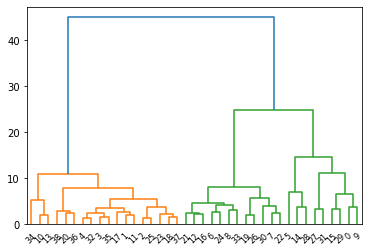

In [16]:
# dendrogram to have an idea about aggregation procedure
# and the evolution between cluster distance

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

Z = linkage(clustering_data, metric=metric, method=linkage_method)
# fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [17]:
# use Calanski-Harabasz index
# to choose the right number of cluster

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics


# where to store CH index
arr_calanski = {}

# max possible number of cluster
max_k = 10

# data
X = clustering_data

# loop over number of clusters
for k in range(2, max_k):
  # build model 
  model = AgglomerativeClustering(n_clusters=k, linkage=linkage_method, affinity=metric)
  model = model.fit(X)

  # clusters label
  labels = model.fit_predict(X)

  # compute calanski metric
  m = metrics.calinski_harabasz_score(X, labels)

  arr_calanski[k] = m


# plot of CH index
fig = go.Figure(data=[
                      go.Scatter(x=list(arr_calanski.keys()), y=list(arr_calanski.values()))
])

fig.update_layout(
    width=800,
    height=500,
    xaxis_title="number of cluster",
    yaxis_title="Calanski-Harbasz index"
)

fig.show()

In [18]:
clustering_data

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
1982,-3.431839,-3.408901,-3.385655,-3.360436,-3.339949,-3.320374,-3.293374,-3.267248,-3.238483,-3.199772,...,3.937460,3.967945,3.999253,4.021615,4.043278,4.066312,4.089704,4.114963,4.136602,4.164539
1983,-3.430723,-3.410097,-3.390112,-3.361881,-3.337052,-3.311240,-3.261550,-3.221451,-3.177961,-3.158774,...,2.716388,2.747344,2.772031,2.795287,2.818365,2.841618,2.864697,2.887989,2.911405,2.935641
1984,-3.428068,-3.407973,-3.389650,-3.369606,-3.349985,-3.329523,-3.310190,-3.291525,-3.270762,-3.242064,...,2.882825,2.906107,2.927824,2.952791,2.977970,3.002083,3.026442,3.051732,3.074509,3.098941
1985,-3.430951,-3.411240,-3.393101,-3.374791,-3.353955,-3.333037,-3.312818,-3.294357,-3.274888,-3.254387,...,2.790755,2.815866,2.838338,2.860505,2.882411,2.904701,2.930664,2.955104,2.981164,3.005997
1986,-3.433193,-3.413685,-3.396259,-3.377460,-3.358982,-3.341638,-3.323254,-3.303297,-3.281220,-3.257375,...,2.928327,2.951148,2.976275,3.001721,3.025769,3.051053,3.075991,3.100270,3.125038,3.149917
1987,-3.431033,-3.407930,-3.383900,-3.344653,-3.324951,-3.305329,-3.276769,-3.255411,-3.233853,-3.213837,...,4.041973,4.067400,4.094951,4.131152,4.157550,4.181881,4.205310,4.229445,4.254592,4.278578
1988,-3.431355,-3.410157,-3.390788,-3.371423,-3.349272,-3.325490,-3.305087,-3.281970,-3.255973,-3.215717,...,3.352362,3.377018,3.401276,3.424833,3.447936,3.472363,3.497200,3.521270,3.544197,3.568823
1989,-3.409596,-3.382404,-3.324644,-3.298289,-3.251935,-3.231131,-3.209786,-3.188921,-3.169862,-3.148531,...,3.389305,3.412457,3.436355,3.460311,3.483692,3.507970,3.532841,3.557615,3.578889,3.604932
1990,-3.427805,-3.407488,-3.381634,-3.350438,-3.324004,-3.302698,-3.279880,-3.252620,-3.224825,-3.190494,...,3.574969,3.599586,3.630421,3.655921,3.682649,3.707614,3.732124,3.758048,3.782949,3.809727
1991,-3.425086,-3.400191,-3.379115,-3.357315,-3.334731,-3.313473,-3.288893,-3.257808,-3.227435,-3.207425,...,3.631571,3.658152,3.686299,3.715715,3.756377,3.781939,3.805788,3.827434,3.852878,3.879000


In [19]:
# perform clustring for k = nb_cluster
from sklearn.cluster import AgglomerativeClustering

# number of clusters
# determined from the plot above
nb_cluster = 3

# data
X = clustering_data

# build clustering model
model = AgglomerativeClustering(n_clusters=nb_cluster, linkage=linkage_method, affinity=metric)
model = model.fit(X)

# assign cluster lable to each observation
cluster_labels = model.fit_predict(X)

In [20]:
cluster_labels

array([0, 1, 1, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2, 1, 0, 0, 2, 1, 1, 2, 1, 2,
       2, 1, 2, 1, 2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 1, 1, 1], dtype=int64)

In [21]:
# create centered data
centered_clustering_data = pd.DataFrame()

for col in clustering_data.columns:
  centered_clustering_data[col] = clustering_data[col] - clustering_data[col].mean()

In [22]:
centered_clustering_data

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
1982,-0.002638,-0.002699,-0.004960,-0.005082,-0.011071,-0.015750,-0.015264,-0.016694,-0.012970,0.000240,...,0.725790,0.731885,0.738434,0.735915,0.731920,0.729083,0.726506,0.726532,0.722947,0.724858
1983,-0.001522,-0.003895,-0.009418,-0.006527,-0.008173,-0.006616,0.016559,0.029103,0.047553,0.041239,...,-0.495281,-0.488717,-0.488788,-0.490413,-0.492994,-0.495611,-0.498501,-0.500441,-0.502250,-0.504040
1984,0.001133,-0.001771,-0.008955,-0.014252,-0.021106,-0.024900,-0.032081,-0.040971,-0.045249,-0.042052,...,-0.328844,-0.329953,-0.332995,-0.332909,-0.333388,-0.335147,-0.336756,-0.336698,-0.339146,-0.340740
1985,-0.001750,-0.005038,-0.012406,-0.019438,-0.025077,-0.028414,-0.034709,-0.043803,-0.049374,-0.054375,...,-0.420915,-0.420195,-0.422482,-0.425195,-0.428947,-0.432528,-0.432534,-0.433326,-0.432491,-0.433684
1986,-0.003992,-0.007482,-0.015565,-0.022106,-0.030103,-0.037015,-0.045145,-0.052743,-0.055707,-0.057362,...,-0.283342,-0.284913,-0.284544,-0.283979,-0.285589,-0.286177,-0.287207,-0.288160,-0.288617,-0.289765
1987,-0.001832,-0.001728,-0.003205,0.010701,0.003927,-0.000706,0.001340,-0.004857,-0.008339,-0.013825,...,0.830303,0.831339,0.834132,0.845453,0.846192,0.844652,0.842112,0.841015,0.840937,0.838896
1988,-0.002154,-0.003955,-0.010093,-0.016069,-0.020394,-0.020867,-0.026977,-0.031416,-0.030460,-0.015705,...,0.140693,0.140957,0.140457,0.139134,0.136577,0.135134,0.134002,0.132840,0.130542,0.129142
1989,0.019605,0.023798,0.056050,0.057065,0.076943,0.073493,0.068323,0.061633,0.055651,0.051482,...,0.177636,0.176396,0.175536,0.174611,0.172334,0.170740,0.169643,0.169185,0.165234,0.165251
1990,0.001396,-0.001285,-0.000940,0.004916,0.004874,0.001926,-0.001770,-0.002065,0.000688,0.009518,...,0.363300,0.363525,0.369601,0.370221,0.371291,0.370385,0.368926,0.369618,0.369294,0.370046
1991,0.004115,0.006011,0.001579,-0.001962,-0.005853,-0.008850,-0.010784,-0.007254,-0.001922,-0.007413,...,0.419901,0.422091,0.425480,0.430015,0.445019,0.444710,0.442590,0.439004,0.439223,0.439319


In [23]:
# perform explanatory PCA decomposition
from sklearn.decomposition import PCA

# build and fit
pca = PCA()
pca.fit(centered_clustering_data)

print(pca.explained_variance_ratio_)

[8.38523546e-01 8.82172498e-02 3.21219724e-02 1.92893525e-02
 4.89436994e-03 4.24893088e-03 2.55407091e-03 2.11052785e-03
 1.50699967e-03 1.04528990e-03 8.80639202e-04 6.83448581e-04
 6.01339046e-04 5.28893735e-04 3.72093594e-04 3.15613714e-04
 2.62671738e-04 2.46819610e-04 2.06059428e-04 1.72476970e-04
 1.55199842e-04 1.34879864e-04 1.34207662e-04 1.08974783e-04
 9.63197991e-05 9.03070364e-05 7.74039679e-05 6.30965191e-05
 6.15124772e-05 5.56694162e-05 4.92328168e-05 3.95650846e-05
 3.86219585e-05 3.05706724e-05 2.68413187e-05 2.28685104e-05
 1.78263294e-05 1.45361091e-05 6.11721272e-33]


In [24]:
# keep 7 components

from sklearn.decomposition import PCA

pca = PCA(n_components=7)
pca.fit(centered_clustering_data)

transformed_centered_clustering_data = pd.DataFrame(pca.transform(centered_clustering_data), index=centered_clustering_data.index)

In [25]:
transformed_centered_clustering_data

,0,1,2,3,4,5,6
1982,4.595163,4.157487,-1.692294,-0.798951,-0.910657,-0.909840,-0.061154
1983,-5.014543,0.845330,1.322923,0.637964,-0.261090,0.165665,-0.253647
1984,-5.426665,0.276133,-1.174414,-0.355947,-0.416806,0.288571,0.395807
1985,-4.360333,-0.243226,0.672353,-0.433866,-0.485390,-0.327766,0.037622
1986,-4.141305,1.049509,0.534766,-0.124886,-0.015558,0.096566,0.104525
1987,10.452393,3.755725,2.425074,3.072694,-0.932190,0.232260,-0.603977
1988,3.735669,-1.414752,1.173626,0.109130,0.034846,0.441085,0.108290
1989,1.175382,0.401389,-1.608421,0.797484,0.127651,-0.227922,-0.456428
1990,4.431630,-2.213788,-1.193225,-0.740385,-0.168011,0.332452,-0.050411
1991,3.633782,2.921074,-1.067700,1.377086,1.007731,0.705399,-0.148439


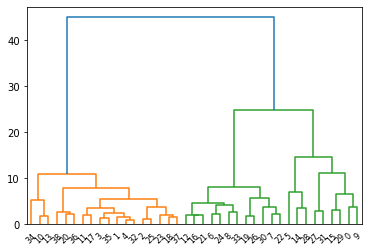

In [26]:
# dendrogram to have an idea about aggregation procedure
# and the evolution between cluster distance

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

Z = linkage(transformed_centered_clustering_data, metric=metric, method=linkage_method)
# fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [27]:
# use Calanski-Harabasz index
# to choose the right number of cluster

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics


# where to store CH index
arr_calanski = {}

# max possible number of cluster
max_k = 10

# data
X = transformed_centered_clustering_data

# loop over number of clusters
for k in range(2, max_k):
  # build model 
  model = AgglomerativeClustering(n_clusters=k, linkage=linkage_method, affinity=metric)
  model = model.fit(X)

  # clusters label
  labels = model.fit_predict(X)

  # compute calanski metric
  m = metrics.calinski_harabasz_score(X, labels)

  arr_calanski[k] = m


# plot of CH index
fig = go.Figure(data=[
                      go.Scatter(x=list(arr_calanski.keys()), y=list(arr_calanski.values()))
])

fig.update_layout(
    width=800,
    height=500,
    xaxis_title="number of cluster",
    yaxis_title="Calanski-Harbasz index"
)

fig.show()

In [28]:
# perform clustring for k = nb_cluster
from sklearn.cluster import AgglomerativeClustering

# number of clusters
# determined from the plot above
nb_cluster = 3

# data
X = transformed_centered_clustering_data

# build clustering model
model = AgglomerativeClustering(n_clusters=nb_cluster, linkage=linkage_method, affinity=metric)
model = model.fit(X)

# assign cluster lable to each observation
cluster_labels = model.fit_predict(X)

In [29]:
cluster_labels

array([0, 1, 1, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2, 1, 0, 0, 2, 1, 1, 2, 1, 2,
       2, 1, 2, 1, 2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 1, 1, 1], dtype=int64)

In [30]:
print([2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 0, 2, 1, 1, 2, 1, 2,
       2, 1, 2, 1, 1, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 2, 1])

[2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 0, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 2, 1]
